# 1. Imports

In [1]:
import psycopg2           as pg
import pandas             as pd
import numpy              as np
import seaborn            as sns
import matplotlib.patches as mpatches
import scikitplot         as skplt

import os 
import pickle

from dotenv                  import load_dotenv
from IPython.core.display    import HTML
from IPython.display         import Image

from sklearn.preprocessing   import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import ExtraTreesClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression

from matplotlib            import pyplot as plt

## 1.1.Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20,8]
    plt.rcParams['font.size'] = 11

    display( HTML( '<style>.container { width:80% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option( 'display.max_columns', None )

    sns.set_style("darkgrid")
    sns.set_palette("muted")
    
    
def precision_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # creating ranking order
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # creating ranking order
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 1.2. Collect Data Using Psycopg2

In [4]:
# DB Credentials
load_dotenv()

host = os.environ.get( 'host' )
port = os.environ.get( 'port' )
database = os.environ.get( 'database' )
username = os.environ.get( 'user' )
pwd = os.environ.get( 'pwd' )

In [5]:
# create DB connection
conn = pg.connect( user=username,
                   password=pwd,
                   host=host,
                   port=port,
                   database=database )

### 1.2.1. Schema Query

In [6]:
# create cursor and execute query
cursor = conn.cursor()

query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
"""

cursor.execute( query_schema )
record = cursor.fetchall()
record

[('pg_toast',),
 ('pg_temp_1',),
 ('pg_toast_temp_1',),
 ('pg_catalog',),
 ('information_schema',),
 ('public',),
 ('pa004',),
 ('pg_temp_4',),
 ('pg_toast_temp_4',),
 ('pa005',),
 ('pg_temp_9',),
 ('pg_toast_temp_9',)]

### 1.2.2. Tables Query 

In [7]:
# create cursor and execute query
cursor = conn.cursor()

query_tables = """
    SELECT tablename
    FROM pg_tables
    WHERE schemaname='pa004'
"""

cursor.execute( query_tables )
record = cursor.fetchall()
record

[('users',), ('vehicle',), ('insurance',)]

### 1.2.3. Collect Data

In [8]:
# create cursor and execute query
cursor = conn.cursor()

query_tables_users = """
    SELECT *
    FROM pa004.users u
    LIMIT 10
"""

cursor.execute( query_tables_users )
record = cursor.fetchall()
record

[(1, 'Male', 44, 28.0, 26.0),
 (2, 'Male', 76, 3.0, 26.0),
 (3, 'Male', 47, 28.0, 26.0),
 (4, 'Male', 21, 11.0, 152.0),
 (5, 'Female', 29, 41.0, 152.0),
 (6, 'Female', 24, 33.0, 160.0),
 (7, 'Male', 23, 11.0, 152.0),
 (8, 'Female', 56, 28.0, 26.0),
 (9, 'Female', 24, 3.0, 152.0),
 (10, 'Female', 32, 6.0, 152.0)]

In [9]:
# close cursor and connection
cursor.close()
conn.close()

In [10]:
# convert to dataframe
data = pd.DataFrame( record )
data.head()

,0,1,2,3,4
0,1,Male,44,28.0,26.0
1,2,Male,76,3.0,26.0
2,3,Male,47,28.0,26.0
3,4,Male,21,11.0,152.0
4,5,Female,29,41.0,152.0


## 1.3. Collect Data Using Pandas

In [11]:
# create DB connection
conn = pg.connect( user=username,
                   password=pwd,
                   host=host,
                   port=port,
                   database=database )

In [12]:
# users table query
query = """
    SELECT *
    FROM pa004.users
    LIMIT 10
"""

df = pd.read_sql( query, conn )
df.head()

,id,gender,age,region_code,policy_sales_channel
0,1,Male,44,28.0,26.0
1,2,Male,76,3.0,26.0
2,3,Male,47,28.0,26.0
3,4,Male,21,11.0,152.0
4,5,Female,29,41.0,152.0


In [13]:
# vehicle table query
query = """
    SELECT *
    FROM pa004.vehicle
    LIMIT 10
"""

df = pd.read_sql( query, conn )
df.head()

,id,driving_license,vehicle_age,vehicle_damage
0,1,1,> 2 Years,Yes
1,2,1,1-2 Year,No
2,3,1,> 2 Years,Yes
3,4,1,< 1 Year,No
4,5,1,< 1 Year,No


In [14]:
# insurance table query
query = """
    SELECT *
    FROM pa004.insurance
    LIMIT 10
"""

df = pd.read_sql( query, conn )
df.head()

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.0,217,1
1,2,0,33536.0,183,0
2,3,0,38294.0,27,1
3,4,1,28619.0,203,0
4,5,1,27496.0,39,0


In [15]:
# join tables
query = """
    SELECT *
    FROM pa004.users u LEFT JOIN pa004.vehicle v ON ( u.id = v.id )
                       LEFT JOIN pa004.insurance i ON ( u.id = i.id )
"""

df_raw = pd.read_sql( query, conn )
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [16]:
# close cursor and connection
cursor.close()
conn.close()

In [17]:
# saving dataset
df_raw = df_raw.loc[:,~df_raw.columns.duplicated()]
df_raw.to_csv("./data/data.csv", encoding='utf-8', index=False)

## 1.4. Loading Data 

In [18]:
df1 = pd.read_csv( 'data/data.csv')
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


# 2. Data Description

In [19]:
df2 = df1.copy()

## 2.1. Renaming Columns

In [20]:
# to lower case
cols_new = df2.columns.str.lower()

# rename columns
df2.columns = cols_new
df2.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

## 2.2. Data Dimensions

In [21]:
print( f'Number of rows: {df2.shape[0]}'  )
print( f'Number of columns: {df2.shape[1]}'  )

Number of rows: 381109
Number of columns: 12


## 2.3. Data Types

In [22]:
df2.dtypes 

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 2.4. Check NA

In [23]:
df2.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 2.5. Descriptive Statistics

### 2.5.1. Numerical Attributes

In [24]:
# dataset with only numerical attributes
num_attributes = df2.select_dtypes( include=[ 'int64', 'float64' ] )
num_attributes.head()

,id,age,region_code,policy_sales_channel,driving_license,previously_insured,annual_premium,vintage,response
0,7,23,11.0,152.0,1,0,23367.0,249,0
1,13,41,15.0,14.0,1,1,31409.0,221,0
2,18,25,35.0,152.0,1,1,46622.0,299,0
3,31,26,8.0,160.0,1,0,2630.0,136,0
4,39,45,8.0,124.0,1,0,42297.0,264,0


In [25]:
# Central Tendency
_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
_median = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion
_min = pd.DataFrame(num_attributes.apply(min)).T
_max = pd.DataFrame(num_attributes.apply(max)).T
_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
_std = pd.DataFrame(num_attributes.apply(np.std)).T
_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
summary = pd.concat([_min, _max, _range, _mean, _median, _std, _skew, _kurtosis]).T.reset_index()
summary.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
summary

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


* Although "driving_license", "previously_insured" and "response" have numerical values, they are considered as categorical attributes, because the numbers represent categories.

### 2.5.2 Categorical Attributes

In [26]:
cat_attributes = df2[['gender', 'vehicle_age', 'vehicle_damage', 'driving_license', 'previously_insured', 'response']]
cat_attributes.head()

,gender,vehicle_age,vehicle_damage,driving_license,previously_insured,response
0,Male,< 1 Year,Yes,1,0,0
1,Female,1-2 Year,No,1,1,0
2,Female,< 1 Year,No,1,1,0
3,Female,< 1 Year,No,1,0,0
4,Male,1-2 Year,Yes,1,0,0


In [27]:
# Qtd. of unique attributes per feature
cat_attributes.apply(lambda x: x.unique().shape[0])

gender                2
vehicle_age           3
vehicle_damage        2
driving_license       2
previously_insured    2
response              2
dtype: int64

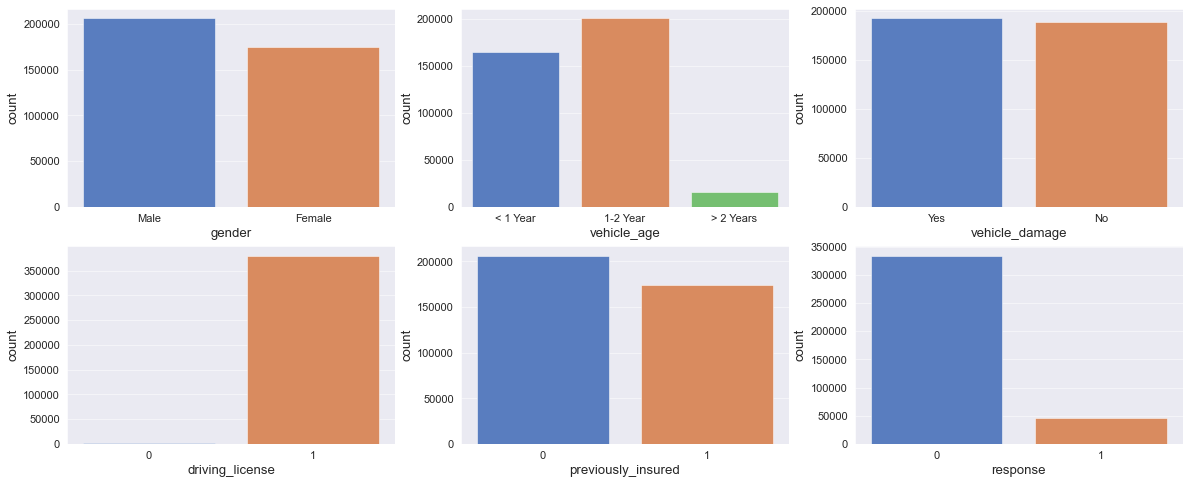

In [28]:
fig, axes = plt.subplots(2,3)

sns.countplot( x='gender'             , data=cat_attributes, ax=axes[0,0] )
sns.countplot( x='vehicle_age'        , data=cat_attributes, ax=axes[0,1] )
sns.countplot( x='vehicle_damage'     , data=cat_attributes, ax=axes[0,2] )
sns.countplot( x='driving_license'    , data=cat_attributes, ax=axes[1,0] )
sns.countplot( x='previously_insured' , data=cat_attributes, ax=axes[1,1] )
sns.countplot( x='response'           , data=cat_attributes, ax=axes[1,2] );

# 3. Feature Engineering

In [29]:
df3 = df2.copy()

## 3.1. Creating New Features

In [30]:
# vehicle age
df3['vehicle_age'] = df3['vehicle_age'].apply( lambda x: 'over_2_years'      if x == '> 2 Years' else
                                                         'between_1_2_years' if x == '1-2 Year' else 
                                                         'below_1_year' )

# vehicle damage
df3['vehicle_damage'] = df3['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)


# check
df3.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,below_1_year,1,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,between_1_2_years,0,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,below_1_year,0,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,below_1_year,0,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,between_1_2_years,1,0,42297.0,264,0


# 4. Data Filtering

In [31]:
df4 = df3.copy()

# 5. EDA

In [32]:
df5 = df4.copy()

## 5.1. Univariate Analysis

### 5.1.1. Age

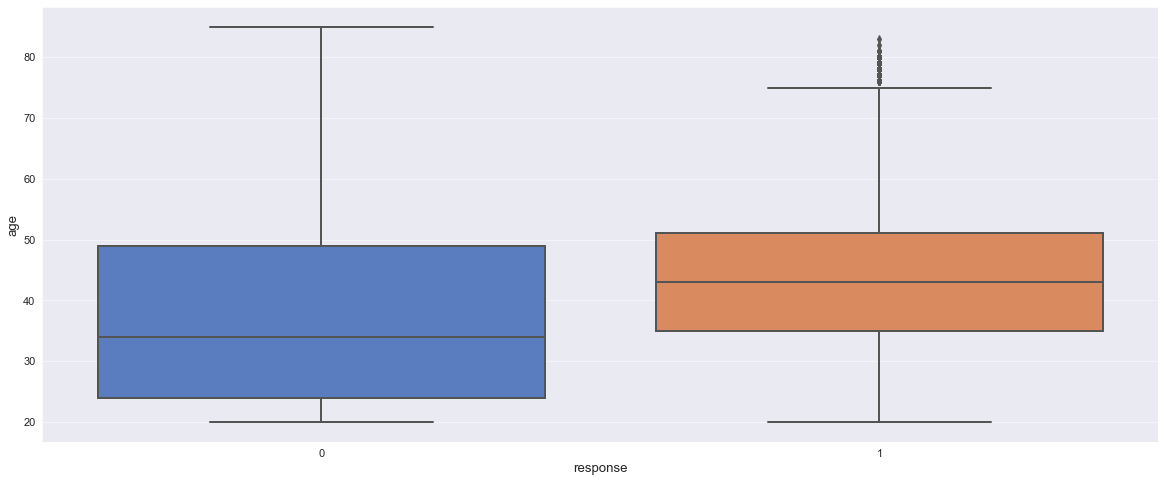

In [33]:
sns.boxplot( x='response', y='age', data=df5  );

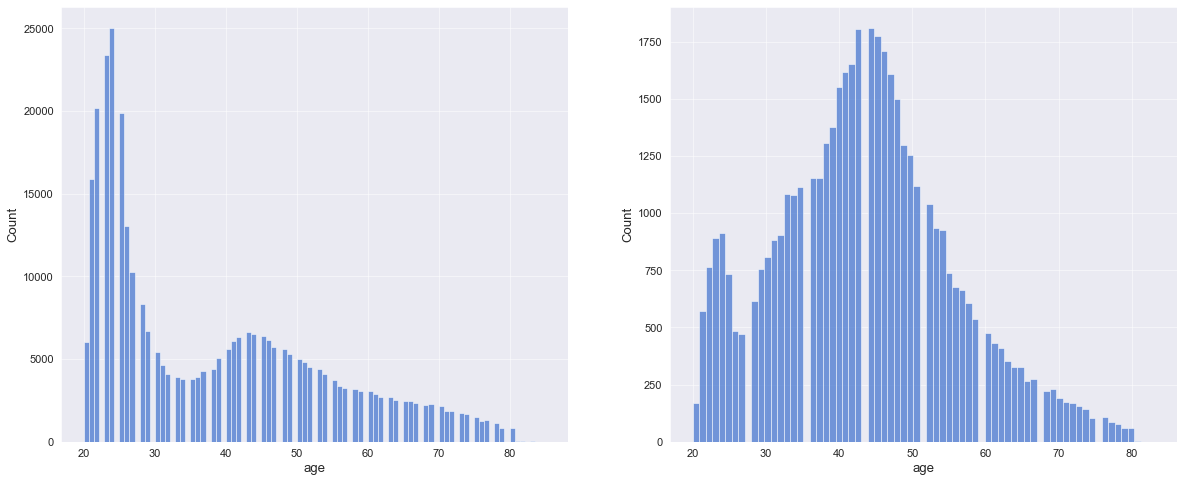

In [34]:
fig, axes = plt.subplots(1,2)

sns.histplot( df5[ df5['response'] == 0 ]['age'], ax=axes[0] )
sns.histplot( df5[ df5['response'] == 1 ]['age'], ax=axes[1] );

* We can see by the distribution that younger people are less interested about the insurance than older people.
    * But we have much more cases of people who are not interested as we can see by comparing the y-axis magnitude.

### 5.1.2. Annual Premium

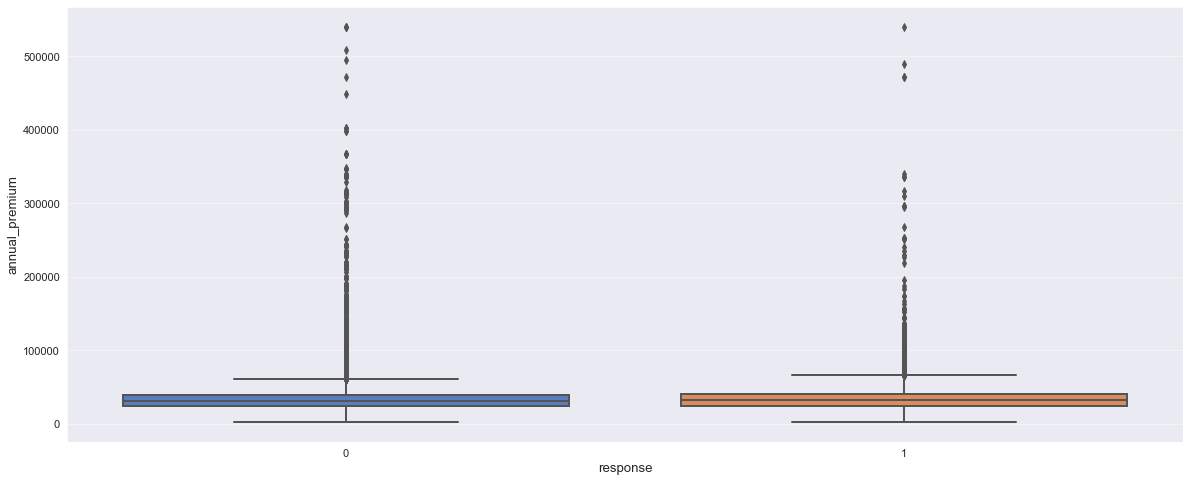

In [35]:
sns.boxplot( x='response', y='annual_premium', data=df5 );

* There is a lot of outliers, so it's hard to analyze the distribution

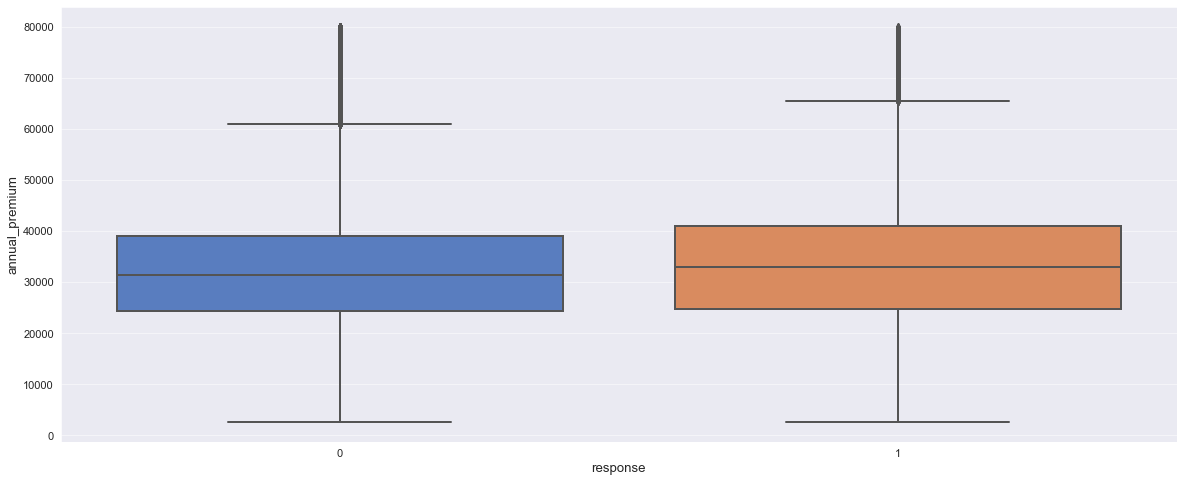

In [36]:
df_aux = df5[ df5['annual_premium'] < 80000 ]
sns.boxplot( x='response', y='annual_premium', data=df_aux );

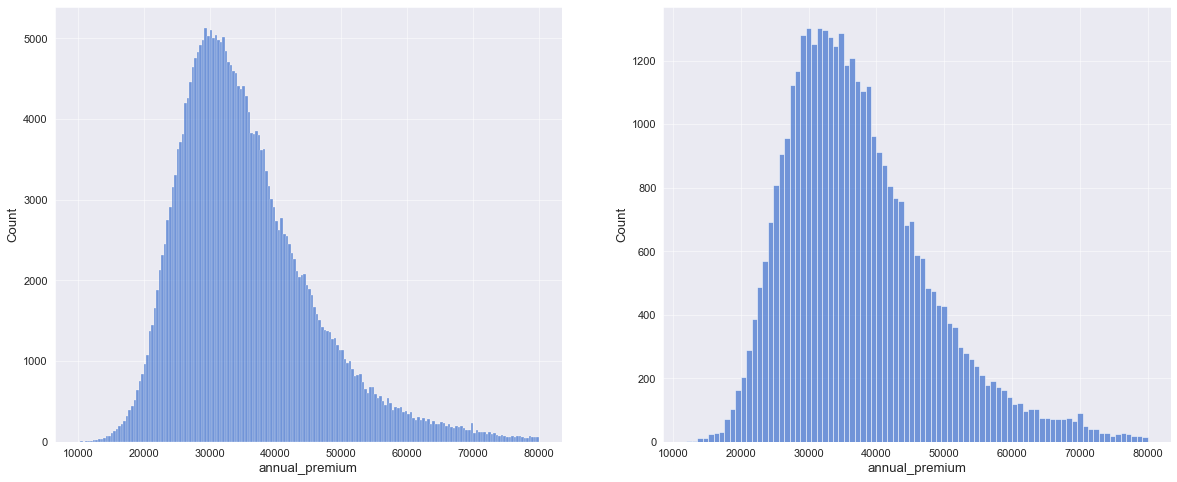

In [37]:
fig, axes = plt.subplots(1,2)

sns.histplot( df5[ (df5['annual_premium'] > 10000) & (df5['annual_premium'] < 80000) & (df5['response'] == 0) ]['annual_premium'] , ax=axes[0])
sns.histplot( df5[ (df5['annual_premium'] > 10000) & (df5['annual_premium'] < 80000) & (df5['response'] == 1) ]['annual_premium'] , ax=axes[1]);

* We can see that the distribution for each response is very similar. This feature alone probably doesn't help the prediction.

### 5.1.3. Driving License

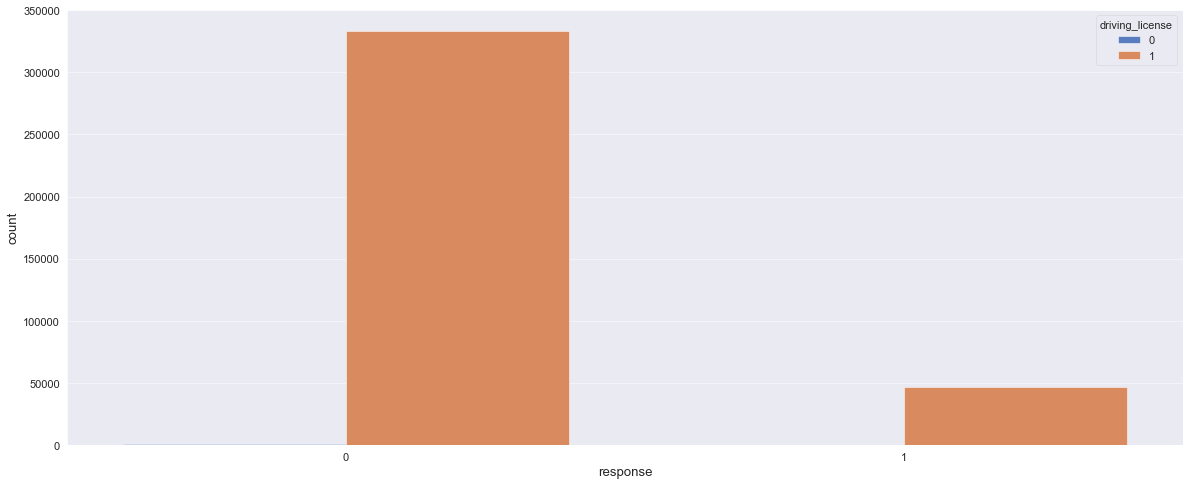

In [38]:
sns.countplot( x='response', hue='driving_license',  data=df5);

* We can see a huge difference in magnitude for people who has a driving license, but I think that we will need to analyse it with another feature, such as age.

### 5.1.4. Region Code

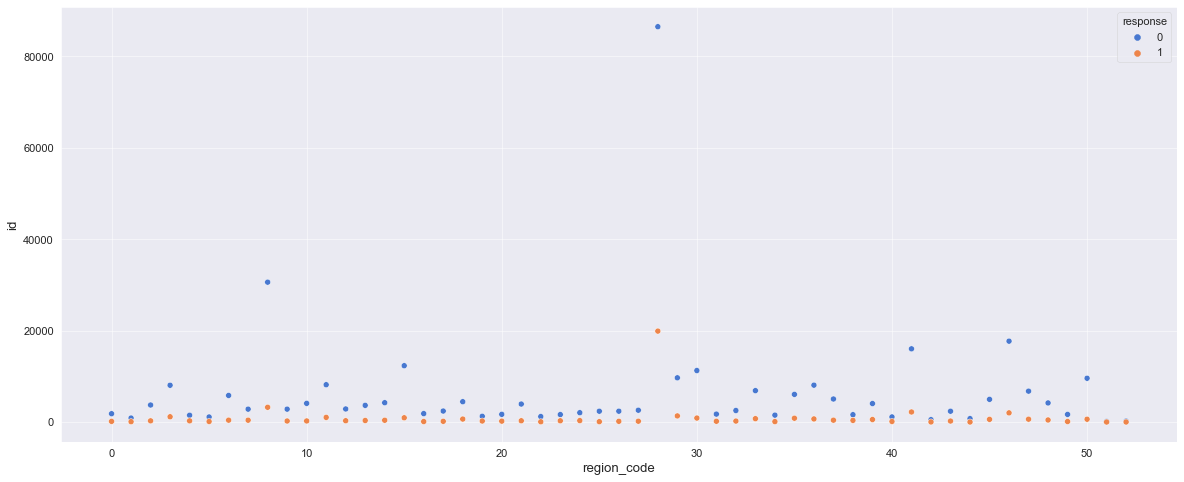

In [39]:
df_aux = df5[ ['id', 'region_code', 'response'] ].groupby( ['region_code', 'response'] ).count().reset_index()
sns.scatterplot( x='region_code', y='id', hue='response', data=df_aux );

* We can see there is no clear separation between interested and not interested people per region code, so this feature alone is not helpful.

### 5.1.5. Previously Insured

In [40]:
pd.crosstab( df5['previously_insured'], df5['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


* Almost everyone that already has a vehicle insurance doesn't want to get a new one.

### 5.1.6. Vehicle Age

In [41]:
df5[ ['vehicle_age', 'response'] ].value_counts( normalize=True ).reset_index().sort_values(by=['vehicle_age'])

,vehicle_age,response,0
1,below_1_year,0,0.413488
4,below_1_year,1,0.018897
0,between_1_2_years,0,0.434285
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
5,over_2_years,1,0.012338


* For cars that has below 2 years there is a clear separation.
 * But over 2 years the percentage is very close, wich can be a problem for the model.

### 5.1.7. Policy Sales Channel

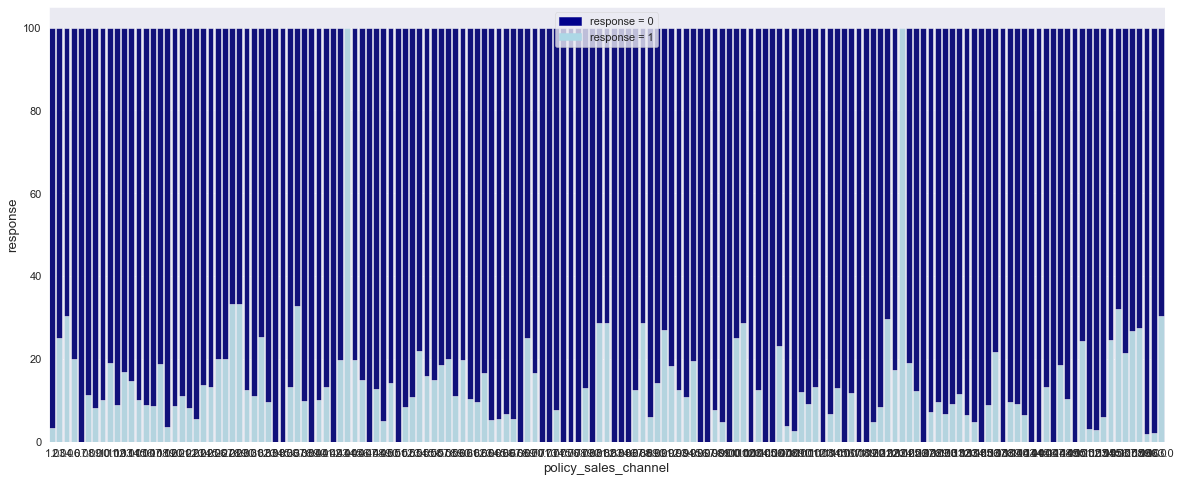

In [42]:
df_total = df5[ ['policy_sales_channel', 'response'] ].groupby( 'policy_sales_channel' ).count().reset_index()
df_resp1 = df5[ ['policy_sales_channel', 'response'] ].groupby( 'policy_sales_channel' ).sum().reset_index()

df_resp1['response'] = [i / j * 100 for i,j in zip(df_resp1['response'], df_total['response'])]
df_total['response'] = 100

bar1 = sns.barplot(x="policy_sales_channel",  y="response", data=df_total, color='darkblue')
bar2 = sns.barplot(x="policy_sales_channel", y="response", data=df_resp1, color='lightblue')

top_bar = mpatches.Patch(color='darkblue', label='response = 0')
bottom_bar = mpatches.Patch(color='lightblue', label='response = 1')
plt.legend(handles=[top_bar, bottom_bar]);

* We can see that for most of the policy sales channel there is a clear difference between the percentages for each response, wich could indicate a good discriminatory feature.

### 5.1.8. Vintage

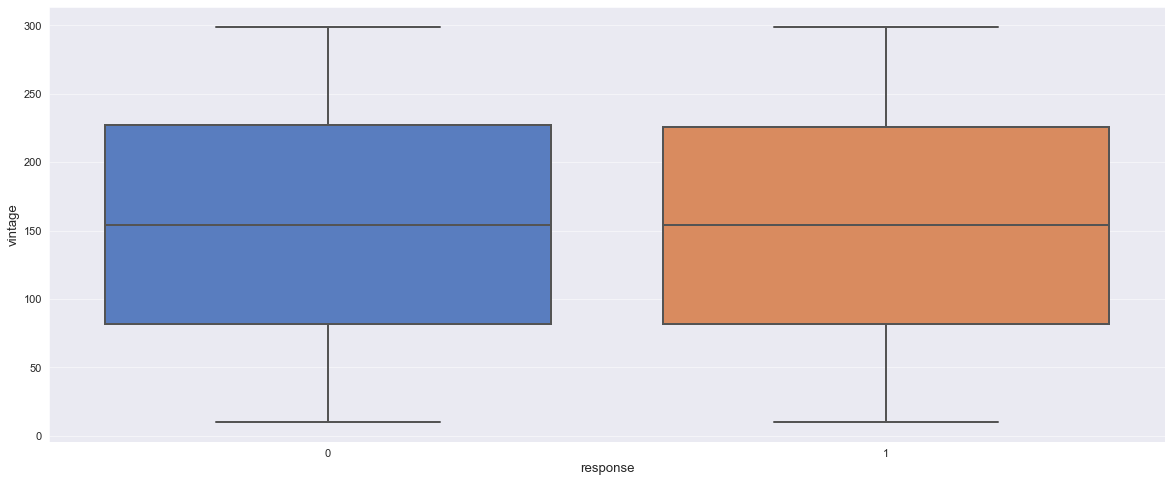

In [43]:
sns.boxplot( x='response', y='vintage', data=df5  );

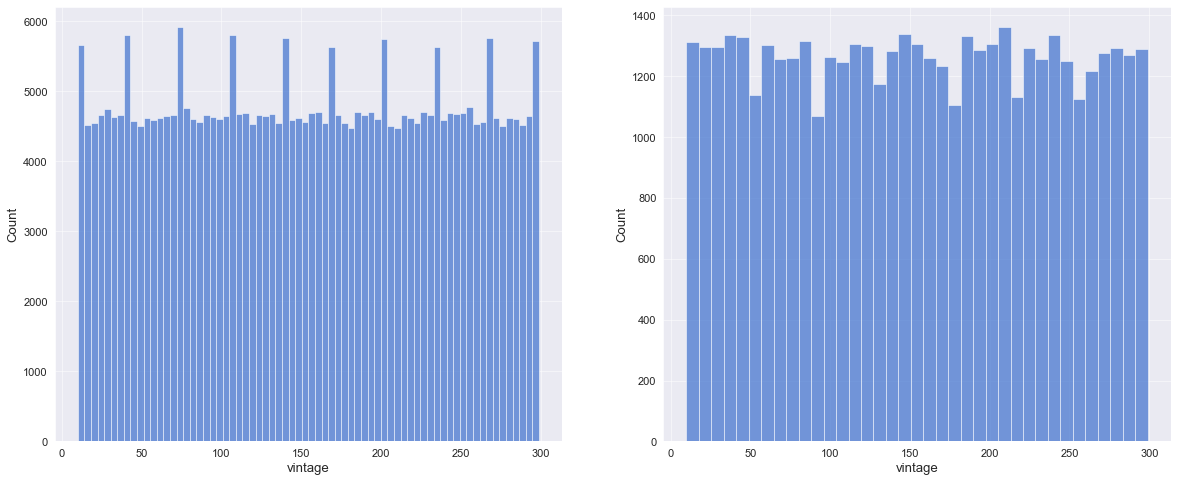

In [44]:
fig, axes = plt.subplots(1,2)

sns.histplot( df5[ df5['response'] == 0 ]['vintage'], ax=axes[0] )
sns.histplot( df5[ df5['response'] == 1 ]['vintage'], ax=axes[1] );

* There is no significant difference between the distributions.

# 6. Data Preparation

In [45]:
X = df5.drop( 'response', axis=1 )
Y = df5['response'].copy()

x_train, x_val, y_train, y_val = train_test_split( X, Y, test_size=0.2 )

df6 = pd.concat( [x_train, y_train], axis=1 )

## 6.1. Standardization

In [46]:
ss = StandardScaler()

# annual_premium
df6['annual_premium'] = ss.fit_transform( df6[['annual_premium']].values )
pickle.dump( ss, open( 'features/annual_premium_scaler.pkl', 'wb' ) )

## 6.2. Rescaling

In [47]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# age
df6['age'] = mms_age.fit_transform( df6[['age']].values )
pickle.dump( mms_age, open( 'features/age_scaler.pkl', 'wb' ) )

# vintage
df6['vintage'] = mms_vintage.fit_transform( df6[['vintage']].values )
pickle.dump( mms_vintage, open( 'features/vintage_scaler.pkl', 'wb' ) )

## 6.3. Encoding

In [48]:
# gender - One Hot Enconding / Target Enconding
target_encode_gender = df6.groupby( 'gender' )['response'].mean()
df6['gender'] = df6['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( 'features/target_encode_gender_scaler.pkl', 'wb' ) )

# region code - Frequency Enconding / Target Enconding / Weighted Target Enconding
target_encode_region_code = df6.groupby( 'region_code' )['response'].mean()
df6['region_code'] = df6['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open( 'features/target_encode_region_code_scaler.pkl', 'wb' ) )
    
# vehicle_age - One Hot Enconding / Order Enconding / Frequency Enconding
df6 = pd.get_dummies( df6, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Enconding / Frequency Enconding
freq_policy_sales_channel = df6.groupby( 'policy_sales_channel' ).size() / len(df6)
df6['policy_sales_channel'] = df6['policy_sales_channel'].map( freq_policy_sales_channel )
pickle.dump( freq_policy_sales_channel, open( 'features/freq_policy_sales_channel_scaler.pkl', 'wb' ) )

## 6.4. Validation Preparation

In [49]:
# gender
x_val['gender'] = x_val['gender'].map( target_encode_gender )

# region_code
x_val['region_code'] = x_val['region_code'].map( target_encode_region_code )

# age
x_val['age'] = mms_age.transform( x_val[['age']].values )

# policy_sales_channel
x_val['policy_sales_channel'] = x_val['policy_sales_channel'].map( freq_policy_sales_channel )

# vehicle_age
x_val = pd.get_dummies( x_val, prefix='vehicle_age', columns=['vehicle_age'] )

# vintage
x_val['vintage'] = mms_vintage.fit_transform( x_val[['vintage']].values )

# annual_premium
x_val['annual_premium'] = ss.fit_transform( x_val[['annual_premium']].values )

# fillna
x_val = x_val.fillna( 0 )

# 7. Feature Selection

## 7.1. Features Importance

In [50]:
# model definition
forest = ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df6.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                         feature  importance
0                        vintage    0.274730
0                 annual_premium    0.245892
0                            age    0.163889
0                    region_code    0.103362
0                 vehicle_damage    0.067562
0           policy_sales_channel    0.059675
0             previously_insured    0.056660
0       vehicle_age_below_1_year    0.014127
0  vehicle_age_between_1_2_years    0.006232
0                         gender    0.005115
0       vehicle_age_over_2_years    0.002285
0                driving_license    0.000470


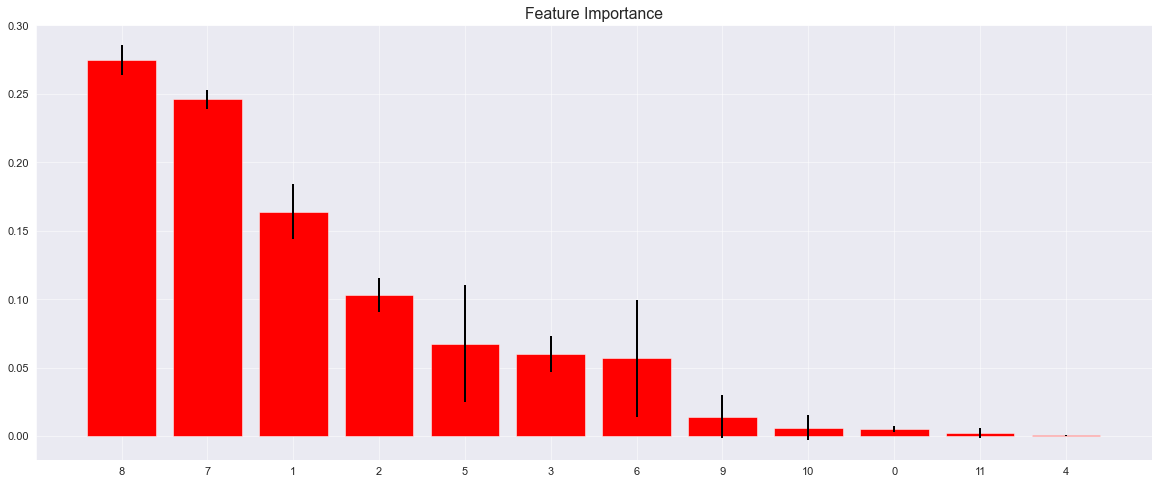

In [51]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort( importances )[::-1]

# print the feature ranking
df = pd.DataFrame()

print( 'Feature Ranking:' )
for i, j in zip( x_train_n, forest.feature_importances_ ):
    df_aux = pd.DataFrame( {'feature':i, 'importance':j}, index=[0] )
    df = pd.concat( [df, df_aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importance')
plt.bar( range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks( range(x_train_n.shape[1]), indices )
plt.xlim( [-1, x_train_n.shape[1]] )
plt.show()

* It will be selected the seven most important feature, because they have a importance over 5\%.

# 8. Machine Learning Model

In [52]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 
                 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

# get selected features
x_train = df6[ cols_selected ]
x_vald = x_val[ cols_selected ]

## 8.1. KNN

In [53]:
# model definition
knn_model = KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( x_vald )

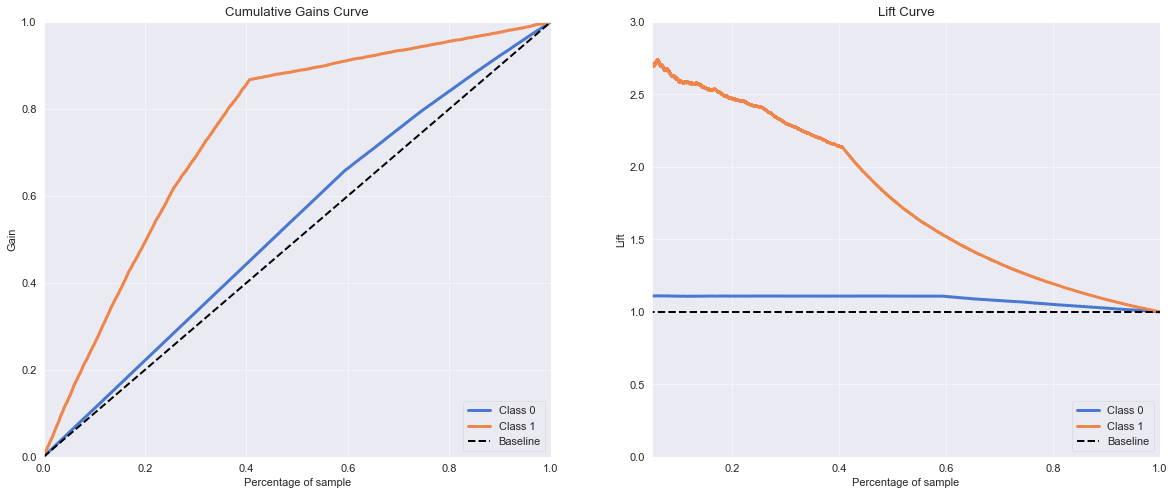

In [54]:
fig, axes = plt.subplots(1,2)

# accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn, ax=axes[0])

# lift curve
skplt.metrics.plot_lift_curve( y_val, yhat_knn, ax=axes[1])
xlim(0.05, 1)
ylim(0, 3);

## 8.2. Logistic Regression

In [55]:
# model definition
lr_model = LogisticRegression( random_state=42 )

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_vald )

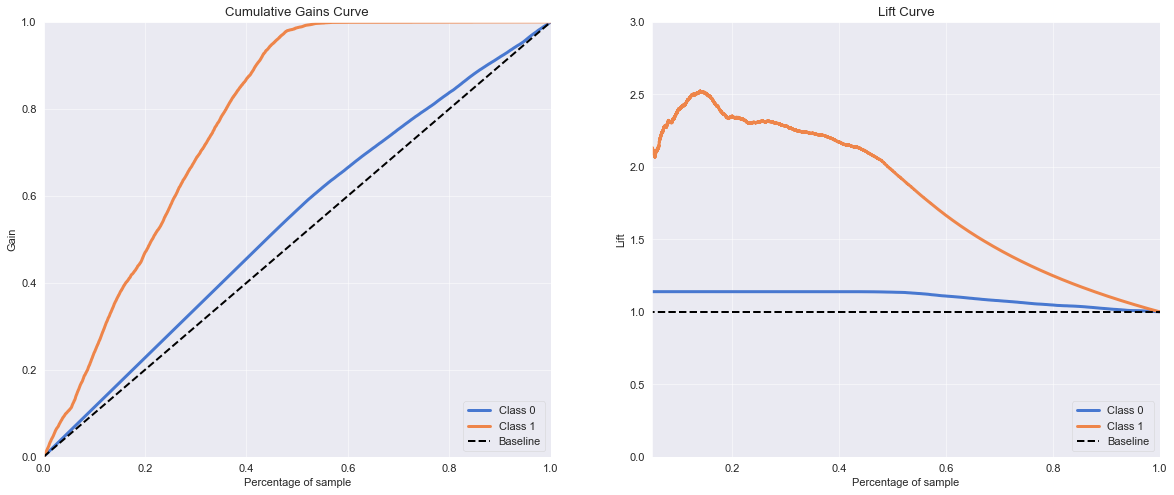

In [56]:
fig, axes = plt.subplots(1,2)

# accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr, ax=axes[0] )

# lift curve
skplt.metrics.plot_lift_curve( y_val, yhat_lr, ax=axes[1] )
xlim(0.05, 1)
ylim(0, 3);

## 8.3. Extra Trees Classifier

In [57]:
# model definition
et_model = ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# model fit
et_model.fit( x_train, y_train )

# model predict
yhat_et = et_model.predict_proba( x_vald )

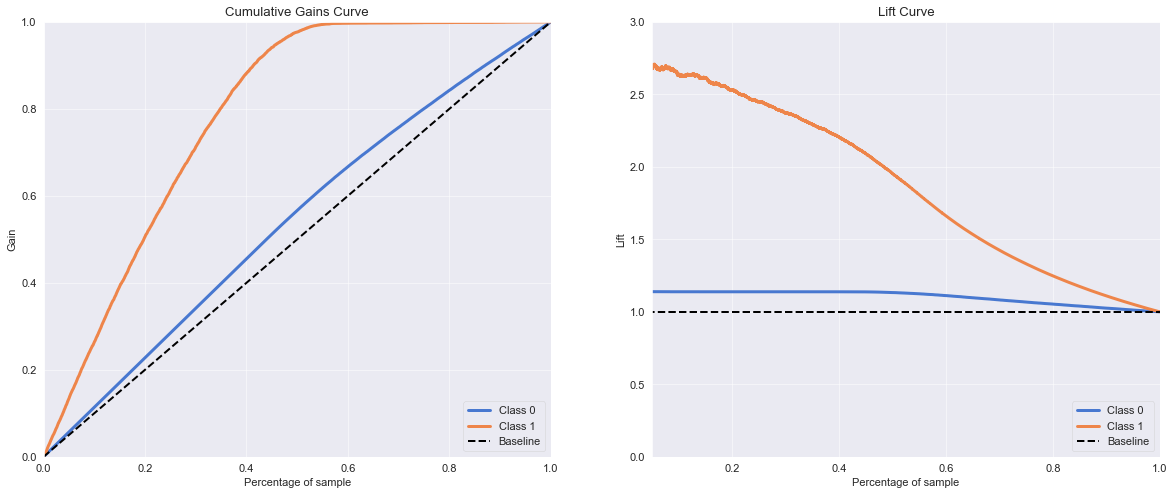

In [58]:
fig, axes = plt.subplots(1,2)

# accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et, ax=axes[0] )

# lift curve
skplt.metrics.plot_lift_curve( y_val, yhat_et, ax=axes[1] )
xlim(0.05, 1)
ylim(0,3);

#  9. Model Performance

* The Logistic Regression model was chosen because of its good results for cumulative gain and lift curve and it's a light model.

In [59]:
# copy data
df9 = x_val.copy()
df9['response'] = y_val.copy()

In [60]:
# propensity score
df9['score'] = yhat_lr[:, 1].tolist()

# sort clients by propensity score
df9 = df9.sort_values( 'score', ascending=False )

# compute precision at K
precision_at_50 = precision_at_k( df9.copy(), k=50 )
print( 'Precision at k: {}'.format( precision_at_50 ) )

# compute recall at K
recall_at_50 = recall_at_k( df9, k=50 )
print( 'Recall at k: {}'.format( recall_at_50 ) )

Precision at k: 0.13725490196078433
Recall at k: 0.0007518796992481203


# 10. Deploy Model to Production

In [61]:
# save trained model
pickle.dump( lr_model, open( 'model/model_linear_regression.pkl', 'wb' ) ) 

## 10.1. Health Insurance Class

In [71]:
import pickle
import os

import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__( self ):
        self.home_path = os.path.abspath('')
        self.annual_premium_scaler            = pickle.load( open( os.path.join(self.home_path, 'features/annual_premium_scaler.pkl'), 'rb' ) )
        self.age_scaler                       = pickle.load( open( os.path.join(self.home_path, 'features/age_scaler.pkl'), 'rb' ) )
        self.vintage_scaler                   = pickle.load( open( os.path.join(self.home_path, 'features/vintage_scaler.pkl'), 'rb' ) )
        self.target_encode_gender_scaler      = pickle.load( open( os.path.join(self.home_path, 'features/target_encode_gender_scaler.pkl'), 'rb' ) )
        self.target_encode_region_code_scaler = pickle.load( open( os.path.join(self.home_path, 'features/target_encode_region_code_scaler.pkl'), 'rb' ) )
        self.freq_policy_sales_channel_scaler = pickle.load( open( os.path.join(self.home_path, 'features/freq_policy_sales_channel_scaler.pkl'), 'rb' ) )
        
        
    def data_cleaning( self, df2 ):
        ## 2.1. Renaming Columns
        # to lower case
        cols_new = df2.columns.str.lower()

        # rename columns
        df2.columns = cols_new
        df2.columns
        
        return df2
    
    
    def feature_engineering( self, df3 ):
        # vehicle age
        df3['vehicle_age'] = df3['vehicle_age'].apply( lambda x: 'over_2_years'      if x == '> 2 Years' else
                                                                 'between_1_2_years' if x == '1-2 Year' else 
                                                                 'below_1_year' )
        
        # vehicle damage
        df3['vehicle_damage'] = df3['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        
        return df3
    
    
    def data_preparation( self, df6 ):
        # annual_premium
        df6['annual_premium'] = self.annual_premium_scaler.fit_transform( df6[['annual_premium']].values )

        # age
        df6['age'] = self.age_scaler.fit_transform( df6[['age']].values )

        # vintage
        df6['vintage'] = self.vintage_scaler.fit_transform( df6[['vintage']].values )
        
        # gender 
        df6['gender'] = df6['gender'].map( self.target_encode_gender_scaler )

        # region code
        df6['region_code'] = df6['region_code'].map( self.target_encode_region_code_scaler )

        # vehicle_age
        df6 = pd.get_dummies( df6, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel
        df6['policy_sales_channel'] = df6['policy_sales_channel'].map( self.freq_policy_sales_channel_scaler )
        
        # feature selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 
                 'vehicle_damage', 'previously_insured', 'policy_sales_channel']
        
        return df6[ cols_selected ]
    
    
    def get_predict( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

# loading model
path = os.path.abspath('')
model = pickle.load( open( os.path.join( path, "model\model_linear_regression.pkl"), 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/healthinsurance/predict', method=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.Dataframe( test_json, index=[0] )
            
        else: # multiple examples
            test_raw = pd.Dataframe( test_json, columns=test_json[0].keys )
            
        # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True )      